# Maximum Entropy Distribution

We consider a probability distribution on 100 equidistant points $a_i$ in the interval $[−1, 1]$. We impose the following prior assumptions:

$$
  E X \in [-0.1, 0.1]\\
  E X^2 \in [0.5, 0.6]\\
  E(3X^3-2x) \in [-0.3, -0.2]\\
  prob(X < 0) \in [0.3, 0.4]
$$

Along with the constraints $1^Tp = 1, p \succeq 0$, these constraints describe a polyhedron of probability distributions.

The following figure shows the maximum entropy distribution that satisfies these constraints.

<img src="https://drive.google.com/uc?export=view&id=1ywyxqG2XwosFJUZv5E8aaEnywiqt4dw4" width="600" align="center"/>

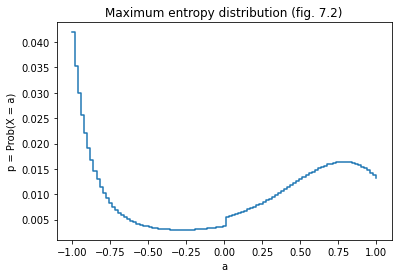

In [1]:
# Figures 7.2 and 7.3, pages 363 and 364.
# Maximum entropy distribution.

from cvxopt import solvers, blas, matrix, spmatrix, spdiag, log, div, reduce
solvers.options['show_progress'] = False

# minimize     p'*log p
# subject to  -0.1 <= a'*p <= 0.1
#              0.5 <= (a**2)'*p <= 0.6
#             -0.3 <= (3*a**3 - 2*a)'*p <= -0.2
#              0.3 <= sum_{k:ak < 0} pk <= 0.4
#              sum(p) = 1
#
# a in R^100 is made of 100 equidistant points in [-1,1].
# The variable is p (100).

n = 100
a = -1.0 + (2.0/(n-1)) * matrix(list(range(n)), (1,n))
I = [k for k in range(n) if a[k] < 0]
G = matrix([-a, a, -a**2, a**2, -(3 * a**3 - 2*a), (3 * a**3 - 2*a),
    matrix(0.0, (2,n))])
G[6,I] = -1.0
G[7,I] =  1.0
h = matrix([0.1, 0.1, -0.5, 0.6, 0.3, -0.2, -0.3, 0.4 ])

A, b = matrix(1.0, (1,n)), matrix(1.0)

# minimize    x'*log x
# subject to  G*x <= h
#             A*x = b
#
# variable x (n).

def F(x=None, z=None):
   if x is None: return 0, matrix(1.0, (n,1))
   if min(x) <= 0: return None
   f = x.T*log(x)
   grad = 1.0 + log(x)
   if z is None: return f, grad.T
   H = spdiag(z[0] * x**-1)
   return f, grad.T, H
sol = solvers.cp(F, G, h, A=A, b=b)
p = sol['x']

def f(x,y): return x+2*[y]
def stepl(x): return reduce(f, x[1:], [x[0]])
def stepr(x): return reduce(f, x[:-1], []) + [x[-1]]

try: import pylab
except ImportError: pass
else:
    pylab.figure(1, facecolor='w')
    pylab.plot(stepl(a), stepr(p), '-')
    pylab.title('Maximum entropy distribution (fig. 7.2)')
    pylab.xlabel('a')
    pylab.ylabel('p = Prob(X = a)')


To illustrate bounding probabilities, we compute upper and lower bounds on the cumulative distribution $prob(X \leq \alpha_i)$, for $i=1,...,100$. For each value of i, we solve two LPs: one that maximizes $prob(X \leq \alpha_i)$ and one that minimizes $prob(X \leq \alpha_i)$ over all distributions consistent with the prior assumptions. 

The upper and lower curves show the upper and lower bounds, respectively; the middle curve shows the cumulative distribution of the maximum entropy distribution.

The results are shown in the following figure:

<img src="https://drive.google.com/uc?export=view&id=1s__4DpXrYXHLECuMtgeYwhtnBqnMJZdf" width="600" align="center"/>


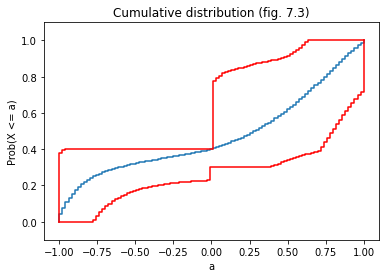

In [2]:
# Upper/lower bounds on cumulative distribution.
#
# minimize/maximize  ck'*p = sum_{i<=alphak} pi
# subject to         G*x <= h
#                    A*x = b
#                    x >= 0
#
# Solve via dual:
#
# maximize    -h'*z - b'*w
# subject to   +/- c + G'*z + A'*w >= 0
#              z >= 0
#
# with variables z (8), w (1).

cc = matrix(0.0, (9,1))
cc[:8], cc[8] = h, b
GG = spmatrix([], [], [], (n+8, 9))
GG[:n,:8] = -G.T
GG[:n,8] = -A.T
GG[n::n+9] = -1.0
hh = matrix(0.0, (n+8,n))
hh[:n,:] = matrix([i>=j for i in range(n) for j in range(n)],
    (n,n), 'd')  # upper triangular matrix of ones
l = [-blas.dot(cc, solvers.lp(cc, GG, hh[:,k])['x']) for k in range(n)]
u = [blas.dot(cc, solvers.lp(cc, GG, -hh[:,k])['x']) for k in range(n)]

try: import pylab
except ImportError: pass
else:
    pylab.figure(2, facecolor='w')
    pylab.plot([-1.0] + stepl(a), [0.0] + stepr(hh[:n,:].T*p), '-',
        [-1.0] + stepl(a), [0.0] + stepr(l), 'r-',
        [-1.0] + stepl(a), [0.0] + stepr(u), 'r-')
    pylab.title('Cumulative distribution (fig. 7.3)')
    pylab.xlabel('a')
    pylab.ylabel('Prob(X <= a)')
    pylab.axis([-1.1, 1.1, -0.1, 1.1])
    pylab.show()